###**objective**



*   explore weather datasets for montreal and area within 100km of montreal
*   source : https://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnProx&timeframe=1&txtRadius=25&optProxType=city&selCity=45%7C31%7C73%7C39%7CMontr%C3%A9al&selPark=&txtCentralLatDeg=&txtCentralLatMin=&txtCentralLatSec=&txtCentralLongDeg=&txtCentralLongMin=&txtCentralLongSec=&txtLatDecDeg=&txtLongDecDeg=&optLimit=yearRange&StartYear=2016&EndYear=2018&Year=2020&Month=5&Day=28&selRowPerPage=25
*   r package : weathercan https://cran.r-project.org/web/packages/weathercan/weathercan.pdf
*   assign weather station id to each trip coordinate
*   remove trips that do not have a sufficient amount of weather station data associated with it



####**dependencies + packages**

In [1]:
!apt install gdal-bin python-gdal python3-gdal 
# install rtree - geopandas requirement
!apt install python3-rtree 
# install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# install descartes - geopandas requirment
!pip install descartes 
# install vincenty module
!pip install vincenty

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-fedhwmj3
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-fedhwmj

In [2]:
from shapely.geometry import box, LineString, MultiLineString, Point, Polygon
from vincenty import vincenty

import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import os
import pandas as pd
import sys

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####**functions**

In [4]:
def merge_series_df(df, series_list, col_rename):
  for i in range(len(series_list)):
    df_series = pd.Series(series_list[i])
    df = pd.concat([df, df_series], axis = 1, sort= False)
    df = df.rename(columns= {0 : col_rename[i]})

  return df

####**weather station data**

In [5]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/environment_canada_historical_weather')

Mounted at /content/drive


In [ ]:
# glossary : https://climate.weather.gc.ca/glossary_e.html#hdd

In [6]:
mtl_weather_hourly = 'mtl_weather_2017_hourly.csv'
mtl_weather_daily = 'mtl_weather_2017_daily.csv'

In [7]:
# import hourly data
mtl_hourly = pd.read_csv(mtl_weather_hourly, index_col = 0)
mtl_hourly.head()

,station_name,station_id,station_operator,prov,lat,lon,elev,climate_id,WMO_id,TC_id,date,time,year,month,day,hour,weather,hmdx,hmdx_flag,pressure,pressure_flag,rel_hum,rel_hum_flag,temp,temp_dew,temp_dew_flag,temp_flag,visib,visib_flag,wind_chill,wind_chill_flag,wind_dir,wind_dir_flag,wind_spd,wind_spd_flag
1,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 00:00:00,2017,9,18,00:00,NaN,25.0,NaN,101.01,NaN,72.0,NaN,20.9,15.7,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,2.0,NaN
2,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 01:00:00,2017,9,18,01:00,NaN,26.0,NaN,101.01,NaN,77.0,NaN,20.8,16.5,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,3.0,NaN
3,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 02:00:00,2017,9,18,02:00,NaN,NaN,NaN,101.01,NaN,85.0,NaN,19.8,17.1,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,2.0,NaN
4,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 03:00:00,2017,9,18,03:00,NaN,NaN,NaN,101.01,NaN,88.0,NaN,18.8,16.8,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,2.0,NaN
5,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 04:00:00,2017,9,18,04:00,NaN,NaN,NaN,101.01,NaN,87.0,NaN,18.6,16.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [8]:
# convert hourly format to integer
mtl_hourly['hour'] = pd.to_datetime(mtl_hourly['time']).dt.hour
mtl_hourly['hour'].head()

1    0
2    1
3    2
4    3
5    4
Name: hour, dtype: int64

In [9]:
geo_location = []

# create geometry coordinates for weather station geo-location
for idx, row in mtl_hourly[['lon', 'lat']].iterrows():
  geo_location.append(Point(row[0], row[1]))

geo_location_series = gpd.GeoSeries(geo_location)

mtl_hourly = pd.concat([mtl_hourly.reset_index(drop = True), geo_location_series.reset_index(drop = True)], axis = 1, sort= False)
mtl_hourly = mtl_hourly.rename(columns= {0 : 'geo_location'})
mtl_hourly.head()

,station_name,station_id,station_operator,prov,lat,lon,elev,climate_id,WMO_id,TC_id,date,time,year,month,day,hour,weather,hmdx,hmdx_flag,pressure,pressure_flag,rel_hum,rel_hum_flag,temp,temp_dew,temp_dew_flag,temp_flag,visib,visib_flag,wind_chill,wind_chill_flag,wind_dir,wind_dir_flag,wind_spd,wind_spd_flag,geo_location
0,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 00:00:00,2017,9,18,0,NaN,25.0,NaN,101.01,NaN,72.0,NaN,20.9,15.7,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,2.0,NaN,POINT (-73.58000 45.50000)
1,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 01:00:00,2017,9,18,1,NaN,26.0,NaN,101.01,NaN,77.0,NaN,20.8,16.5,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,3.0,NaN,POINT (-73.58000 45.50000)
2,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 02:00:00,2017,9,18,2,NaN,NaN,NaN,101.01,NaN,85.0,NaN,19.8,17.1,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,2.0,NaN,POINT (-73.58000 45.50000)
3,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 03:00:00,2017,9,18,3,NaN,NaN,NaN,101.01,NaN,88.0,NaN,18.8,16.8,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,2.0,NaN,POINT (-73.58000 45.50000)
4,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 04:00:00,2017,9,18,4,NaN,NaN,NaN,101.01,NaN,87.0,NaN,18.6,16.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,POINT (-73.58000 45.50000)


In [10]:
# get weather station info
weather_stations = mtl_hourly[['station_id', 'station_name', 'geo_location']].drop_duplicates()
weather_stations

,station_id,station_name,geo_location
0,10761,MCTAVISH,POINT (-73.58000 45.50000)
744,51157,MONTREAL INTL A,POINT (-73.74000 45.47000)
1488,30165,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,POINT (-73.74000 45.47000)
2232,48374,MONTREAL/ST-HUBERT,POINT (-73.42000 45.52000)
2976,10873,STE-ANNE-DE-BELLEVUE 1,POINT (-73.93000 45.43000)
3720,10843,L'ACADIE,POINT (-73.35000 45.29000)
4464,49608,MONTREAL MIRABEL INTL A,POINT (-74.04000 45.68000)
5208,5237,L'ASSOMPTION,POINT (-73.43000 45.81000)
5952,10762,STE-CLOTILDE,POINT (-73.68000 45.17000)
6696,10982,ST-ANICET 1,POINT (-74.29000 45.12000)


In [11]:
# import daily weather activity
mtl_daily = pd.read_csv(mtl_weather_daily, index_col = 0)
mtl_daily.head()

,station_name,station_id,station_operator,prov,lat,lon,elev,climate_id,WMO_id,TC_id,date,year,month,day,qual,cool_deg_days,cool_deg_days_flag,dir_max_gust,dir_max_gust_flag,heat_deg_days,heat_deg_days_flag,max_temp,max_temp_flag,mean_temp,mean_temp_flag,min_temp,min_temp_flag,snow_grnd,snow_grnd_flag,spd_max_gust,spd_max_gust_flag,total_precip,total_precip_flag,total_rain,total_rain_flag,total_snow,total_snow_flag
1,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612,WTA,2017-09-18,2017,9,18,NaN,3.4,NaN,NaN,NaN,0.0,NaN,25.9,NaN,21.4,NaN,16.9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,M,NaN,M
2,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612,WTA,2017-09-19,2017,9,19,NaN,5.3,NaN,NaN,NaN,0.0,NaN,27.6,NaN,23.3,NaN,18.9,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,M,NaN,M
3,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612,WTA,2017-09-20,2017,9,20,NaN,4.1,NaN,NaN,NaN,0.0,NaN,26.1,NaN,22.1,NaN,18.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,M,NaN,M
4,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612,WTA,2017-09-21,2017,9,21,NaN,2.3,NaN,NaN,NaN,0.0,NaN,25.9,NaN,20.3,NaN,14.7,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,M,NaN,M
5,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612,WTA,2017-09-22,2017,9,22,NaN,2.3,NaN,NaN,NaN,0.0,NaN,26.1,NaN,20.3,NaN,14.5,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,M,NaN,M


In [12]:
mtl_daily[['station_id', 'station_name', 'total_precip']][mtl_daily['date'] == '2017-10-08']

,station_id,station_name,total_precip
21,10761,MCTAVISH,6.9
52,51157,MONTREAL INTL A,6.4
83,30165,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,5.5
114,48374,MONTREAL/ST-HUBERT,13.0
145,10873,STE-ANNE-DE-BELLEVUE 1,7.0
176,10843,L'ACADIE,8.5
207,5237,L'ASSOMPTION,18.1
238,10762,STE-CLOTILDE,6.1
269,10982,ST-ANICET 1,2.0
300,10815,FRELIGHSBURG,11.5


In [14]:
# create df that contains if there was precipitation recorded
weather_stn_precip = mtl_daily[['date', 'total_precip']][mtl_daily['station_id'] == weather_stations['station_id'].loc[0]]
weather_stn_precip = weather_stn_precip.set_index('date')
weather_stn_precip = weather_stn_precip.rename(columns = {'total_precip' : weather_stations['station_name'].loc[0]})

for idx, row in weather_stations[['station_id', 'station_name']].loc[1:].iterrows():
  df = mtl_daily[['date', 'total_precip']][mtl_daily['station_id'] == row[0]]
  df = df.set_index('date')
  df = df.rename(columns= {'total_precip' : row[1]})

  weather_stn_precip = pd.concat([weather_stn_precip, df], axis= 1, )

weather_stn_precip = weather_stn_precip.reset_index()
weather_stn_precip['precip_flag'] = np.where(weather_stn_precip.loc[:, 'MCTAVISH':'STE-ANNE-DE-BELLEVUE 1'].sum(axis = 1) > 0, 1, 0)

weather_stn_precip

,date,MCTAVISH,MONTREAL INTL A,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,MONTREAL/ST-HUBERT,STE-ANNE-DE-BELLEVUE 1,L'ACADIE,MONTREAL MIRABEL INTL A,L'ASSOMPTION,STE-CLOTILDE,ST-ANICET 1,GRANBY,FRELIGHSBURG,LAC SAINT-PIERRE,SAINT-GERMAIN-DE-GRANTHAM,ST-JOVITE,precip_flag
0,2017-09-18,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.4,0.0,NaN,0.0,NaN,0.0,0.0,0
1,2017-09-19,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0
2,2017-09-20,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0
3,2017-09-21,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0
4,2017-09-22,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.3,0.0,NaN,0.0,NaN,0.0,0.0,0
5,2017-09-23,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.4,0.0,NaN,0.0,NaN,0.0,0.0,0
6,2017-09-24,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.3,0.0,NaN,0.0,NaN,0.0,0.0,0
7,2017-09-25,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.3,0.0,NaN,0.0,NaN,0.0,0.0,0
8,2017-09-26,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0
9,2017-09-27,5.0,5.6,5.0,2.0,3.6,1.6,NaN,6.0,2.7,0.0,NaN,1.4,NaN,6.9,7.0,1


In [15]:
# summarize how many days precipitation was recorded by weather station
mtl_daily_precip = {}

for stn in weather_stations['station_name']:
  mtl_daily_precip[stn] = len(weather_stn_precip[stn][weather_stn_precip[stn] > 0])

mtl_daily_precip

{'FRELIGHSBURG': 6,
 'GRANBY': 0,
 "L'ACADIE": 10,
 "L'ASSOMPTION": 6,
 'LAC SAINT-PIERRE': 0,
 'MCTAVISH': 6,
 'MONTREAL INTL A': 7,
 'MONTREAL MIRABEL INTL A': 0,
 'MONTREAL/PIERRE ELLIOTT TRUDEAU INTL': 6,
 'MONTREAL/ST-HUBERT': 6,
 'SAINT-GERMAIN-DE-GRANTHAM': 7,
 'ST-ANICET 1': 5,
 'ST-JOVITE': 6,
 'STE-ANNE-DE-BELLEVUE 1': 6,
 'STE-CLOTILDE': 17}

In [16]:
# query daily temperature / precipitation
mtl_daily[['station_id', 'station_name', 'date', 'max_temp', 'min_temp', 'total_precip']].head()

,station_id,station_name,date,max_temp,min_temp,total_precip
1,10761,MCTAVISH,2017-09-18,25.9,16.9,0.0
2,10761,MCTAVISH,2017-09-19,27.6,18.9,0.0
3,10761,MCTAVISH,2017-09-20,26.1,18.0,0.0
4,10761,MCTAVISH,2017-09-21,25.9,14.7,0.0
5,10761,MCTAVISH,2017-09-22,26.1,14.5,0.0


In [17]:
print ('no. of records : {}'.format(len(mtl_daily)))

no. of records : 403


In [18]:
# review temperature, visibility, wind speed and dew
mtl_hourly[['station_id', 'station_name', 'time', 'hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd']].head()

,station_id,station_name,time,hmdx,pressure,rel_hum,temp,temp_dew,visib,wind_spd
0,10761,MCTAVISH,2017-09-18 00:00:00,25.0,101.01,72.0,20.9,15.7,NaN,2.0
1,10761,MCTAVISH,2017-09-18 01:00:00,26.0,101.01,77.0,20.8,16.5,NaN,3.0
2,10761,MCTAVISH,2017-09-18 02:00:00,NaN,101.01,85.0,19.8,17.1,NaN,2.0
3,10761,MCTAVISH,2017-09-18 03:00:00,NaN,101.01,88.0,18.8,16.8,NaN,2.0
4,10761,MCTAVISH,2017-09-18 04:00:00,NaN,101.01,87.0,18.6,16.4,NaN,0.0


In [19]:
# create precipitation flag to join with hourly data
# initialize df
precip = weather_stn_precip[['date', 'MCTAVISH']]
precip['station_name'] = 'MCTAVISH'
precip['MCTAVISH'] = np.where(precip['MCTAVISH'] > 0, 1, 0)
precip = precip.rename(columns= {'MCTAVISH' : 'precip_flag'})

for row in weather_stations['station_name'].loc[1:]:
  df = weather_stn_precip[['date', row]]
  df['station_name'] = row
  df[row] = np.where(df[row] > 0, 1, 0)
  df = df.rename(columns= {row : 'precip_flag'})

  precip = pd.concat([precip, df], axis= 0)

precip

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,date,precip_flag,station_name
0,2017-09-18,0,MCTAVISH
1,2017-09-19,0,MCTAVISH
2,2017-09-20,0,MCTAVISH
3,2017-09-21,0,MCTAVISH
4,2017-09-22,0,MCTAVISH
...,...,...,...
26,2017-10-14,1,ST-JOVITE
27,2017-10-15,1,ST-JOVITE
28,2017-10-16,0,ST-JOVITE
29,2017-10-17,0,ST-JOVITE


In [20]:
# merge hourly data with precipitation flag
mtl_hourly = mtl_hourly.merge(precip, how= 'left', on= ['date', 'station_name'])
mtl_hourly.head()

,station_name,station_id,station_operator,prov,lat,lon,elev,climate_id,WMO_id,TC_id,date,time,year,month,day,hour,weather,hmdx,hmdx_flag,pressure,pressure_flag,rel_hum,rel_hum_flag,temp,temp_dew,temp_dew_flag,temp_flag,visib,visib_flag,wind_chill,wind_chill_flag,wind_dir,wind_dir_flag,wind_spd,wind_spd_flag,geo_location,precip_flag
0,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 00:00:00,2017,9,18,0,NaN,25.0,NaN,101.01,NaN,72.0,NaN,20.9,15.7,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,2.0,NaN,POINT (-73.58000 45.50000),0
1,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 01:00:00,2017,9,18,1,NaN,26.0,NaN,101.01,NaN,77.0,NaN,20.8,16.5,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,3.0,NaN,POINT (-73.58000 45.50000),0
2,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 02:00:00,2017,9,18,2,NaN,NaN,NaN,101.01,NaN,85.0,NaN,19.8,17.1,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,2.0,NaN,POINT (-73.58000 45.50000),0
3,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 03:00:00,2017,9,18,3,NaN,NaN,NaN,101.01,NaN,88.0,NaN,18.8,16.8,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,2.0,NaN,POINT (-73.58000 45.50000),0
4,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-09-18,2017-09-18 04:00:00,2017,9,18,4,NaN,NaN,NaN,101.01,NaN,87.0,NaN,18.6,16.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,POINT (-73.58000 45.50000),0


In [21]:
# check
mtl_hourly[(mtl_hourly['station_name'] == 'MCTAVISH') & (mtl_hourly['date'] == '2017-10-15')].head()

,station_name,station_id,station_operator,prov,lat,lon,elev,climate_id,WMO_id,TC_id,date,time,year,month,day,hour,weather,hmdx,hmdx_flag,pressure,pressure_flag,rel_hum,rel_hum_flag,temp,temp_dew,temp_dew_flag,temp_flag,visib,visib_flag,wind_chill,wind_chill_flag,wind_dir,wind_dir_flag,wind_spd,wind_spd_flag,geo_location,precip_flag
648,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-10-15,2017-10-15 00:00:00,2017,10,15,0,NaN,NaN,NaN,101.02,NaN,89.0,NaN,16.1,14.3,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,3.0,NaN,POINT (-73.58000 45.50000),1
649,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-10-15,2017-10-15 01:00:00,2017,10,15,1,NaN,NaN,NaN,100.88,NaN,88.0,NaN,16.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,3.0,NaN,POINT (-73.58000 45.50000),1
650,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-10-15,2017-10-15 02:00:00,2017,10,15,2,NaN,NaN,NaN,100.80,NaN,92.0,NaN,15.6,14.2,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,2.0,NaN,POINT (-73.58000 45.50000),1
651,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-10-15,2017-10-15 03:00:00,2017,10,15,3,NaN,NaN,NaN,100.69,NaN,93.0,NaN,15.3,14.1,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,3.0,NaN,POINT (-73.58000 45.50000),1
652,MCTAVISH,10761,NaN,QC,45.5,-73.58,72.8,7024745,71612.0,WTA,2017-10-15,2017-10-15 04:00:00,2017,10,15,4,NaN,NaN,NaN,100.58,NaN,96.0,NaN,14.9,14.2,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,1.0,NaN,POINT (-73.58000 45.50000),1


In [22]:
# average metrics where precip_flag = 1 by day
mtl_hourly[mtl_hourly['precip_flag'] == 1].groupby(['station_id', 'station_name', 'month', 'day'])\
['hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,station_id,station_name,month,day,hmdx,pressure,rel_hum,temp,temp_dew,visib,wind_spd
0,5237,L'ASSOMPTION,9,27,NaN,100.557083,NaN,22.800000,NaN,NaN,9.083333
1,5237,L'ASSOMPTION,10,4,NaN,101.634583,NaN,17.808333,NaN,NaN,11.083333
2,5237,L'ASSOMPTION,10,7,NaN,101.246250,NaN,11.570833,NaN,NaN,3.416667
3,5237,L'ASSOMPTION,10,8,NaN,100.526667,NaN,19.912500,NaN,NaN,13.875000
4,5237,L'ASSOMPTION,10,9,NaN,101.027083,NaN,15.437500,NaN,NaN,5.583333
...,...,...,...,...,...,...,...,...,...,...,...
83,51157,MONTREAL INTL A,10,7,NaN,100.980000,89.625000,16.037500,14.320833,21.829167,12.750000
84,51157,MONTREAL INTL A,10,8,26.50,100.342083,76.375000,20.366667,15.962500,30.758333,24.000000
85,51157,MONTREAL INTL A,10,9,NaN,100.783333,92.791667,16.545833,15.370833,16.529167,10.666667
86,51157,MONTREAL INTL A,10,14,NaN,101.711667,83.583333,16.050000,13.245833,22.900000,11.416667


In [23]:
# average metrics where precip_flag = 0 by day
# results indicate that there is a difference in weather forecast KPIs
mtl_hourly[mtl_hourly['precip_flag'] == 0].groupby(['station_id', 'station_name', 'month', 'day'])\
['hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,station_id,station_name,month,day,hmdx,pressure,rel_hum,temp,temp_dew,visib,wind_spd
0,5237,L'ASSOMPTION,9,18,30.333333,101.734583,89.833333,18.337500,18.916667,NaN,4.416667
1,5237,L'ASSOMPTION,9,19,31.727273,101.587083,81.923077,20.529167,19.830769,NaN,4.291667
2,5237,L'ASSOMPTION,9,20,30.083333,101.543333,81.588235,20.729167,18.535294,NaN,7.166667
3,5237,L'ASSOMPTION,9,21,25.000000,101.854583,75.307692,17.937500,11.984615,NaN,7.125000
4,5237,L'ASSOMPTION,9,22,NaN,101.816250,NaN,18.054167,NaN,NaN,4.875000
...,...,...,...,...,...,...,...,...,...,...,...
372,51157,MONTREAL INTL A,10,12,NaN,102.640000,61.500000,9.633333,1.925000,36.200000,12.875000
373,51157,MONTREAL INTL A,10,13,NaN,102.181667,62.291667,12.758333,5.245833,36.200000,13.916667
374,51157,MONTREAL INTL A,10,16,NaN,101.353333,63.875000,6.379167,-0.025000,30.083333,16.833333
375,51157,MONTREAL INTL A,10,17,NaN,101.605833,67.250000,8.233333,2.162500,35.191667,18.708333


In [24]:
# calculate average by each weather station precip_flag = 1
mtl_hourly[mtl_hourly['precip_flag'] == 1].groupby(['station_id', 'station_name'])\
['hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,station_id,station_name,hmdx,pressure,rel_hum,temp,temp_dew,visib,wind_spd
0,5237,L'ASSOMPTION,NaN,100.881736,NaN,17.259722,NaN,NaN,9.131944
1,10761,MCTAVISH,28.744681,100.232986,79.708333,18.965972,15.110417,NaN,6.034722
2,10762,STE-CLOTILDE,31.080357,101.050294,77.813725,16.229412,11.828186,NaN,6.497549
3,10815,FRELIGHSBURG,28.551020,98.531806,83.201389,18.701389,15.538194,NaN,9.333333
4,10843,L'ACADIE,28.650000,NaN,76.404167,15.773750,11.191667,NaN,13.050000
5,10868,ST-JOVITE,31.111111,98.521944,96.097222,14.293750,13.575694,NaN,2.548611
6,10873,STE-ANNE-DE-BELLEVUE 1,28.960000,100.622986,85.465278,18.279167,15.493056,NaN,10.229167
7,10982,ST-ANICET 1,28.183673,100.558333,81.508333,18.670000,15.056667,NaN,11.466667
8,30165,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,28.958333,100.672986,81.812500,18.905556,15.462500,NaN,15.423611
9,47587,SAINT-GERMAIN-DE-GRANTHAM,28.205882,100.219024,82.243902,16.494512,13.246951,NaN,14.689024


In [25]:
# calculate average by each weather station precip_flag = 0
mtl_hourly[mtl_hourly['precip_flag'] == 0].groupby(['station_id', 'station_name'])\
['hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd'].mean().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,station_id,station_name,hmdx,pressure,rel_hum,temp,temp_dew,visib,wind_spd
0,5237,L'ASSOMPTION,30.566667,101.858865,81.981818,14.609349,17.376364,NaN,6.869783
1,10761,MCTAVISH,30.553333,101.182117,64.468333,16.457667,9.377333,NaN,5.916667
2,10762,STE-CLOTILDE,30.125000,101.416845,73.991071,14.333333,9.263988,NaN,6.261905
3,10815,FRELIGHSBURG,30.213115,99.368094,74.689713,14.803204,9.918550,NaN,6.467116
4,10843,L'ACADIE,31.046729,NaN,73.974206,15.503175,10.412698,NaN,7.412698
5,10868,ST-JOVITE,31.068966,99.202387,83.754591,12.293322,9.001836,NaN,2.272120
6,10873,STE-ANNE-DE-BELLEVUE 1,31.100000,101.598632,75.905405,15.176014,10.512331,NaN,8.226351
7,10975,LAC SAINT-PIERRE,29.326531,NaN,75.349462,15.722715,11.067339,NaN,17.458333
8,10982,ST-ANICET 1,31.797203,101.427500,76.554487,15.386859,10.749199,NaN,7.575321
9,30165,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,30.549020,101.644758,68.420701,16.229215,9.985810,NaN,11.343907


In [26]:
# query dataset and determine how many missing values there are for each weather station
weather_signals = ['hmdx', 'pressure', 'rel_hum', 'temp', 'temp_dew','visib', 'wind_spd']

for stn in weather_stations['station_name']:
  print ('\nstation name : {}'.format(stn))
  for sig in weather_signals:
    print('signal : {} - {}'.format(sig, len(mtl_hourly[(mtl_hourly[sig].isna()) & (mtl_hourly['station_name'] == stn)])))

# results :
# L'ACADIE - 744 missing records (pressure)
# LAC SAINT-PIERRE - 744 missing records (pressure)
# SAINT-GERMAIN-DE-GRANTHAM - 39 missing records


station name : MCTAVISH
signal : hmdx - 547
signal : pressure - 0
signal : rel_hum - 0
signal : temp - 0
signal : temp_dew - 0
signal : visib - 744
signal : wind_spd - 0

station name : MONTREAL INTL A
signal : hmdx - 550
signal : pressure - 0
signal : rel_hum - 0
signal : temp - 0
signal : temp_dew - 0
signal : visib - 0
signal : wind_spd - 0

station name : MONTREAL/PIERRE ELLIOTT TRUDEAU INTL
signal : hmdx - 543
signal : pressure - 1
signal : rel_hum - 1
signal : temp - 1
signal : temp_dew - 1
signal : visib - 744
signal : wind_spd - 1

station name : MONTREAL/ST-HUBERT
signal : hmdx - 569
signal : pressure - 3
signal : rel_hum - 3
signal : temp - 3
signal : temp_dew - 3
signal : visib - 3
signal : wind_spd - 3

station name : STE-ANNE-DE-BELLEVUE 1
signal : hmdx - 564
signal : pressure - 8
signal : rel_hum - 8
signal : temp - 8
signal : temp_dew - 8
signal : visib - 744
signal : wind_spd - 8

station name : L'ACADIE
signal : hmdx - 597
signal : pressure - 744
signal : rel_hum - 0


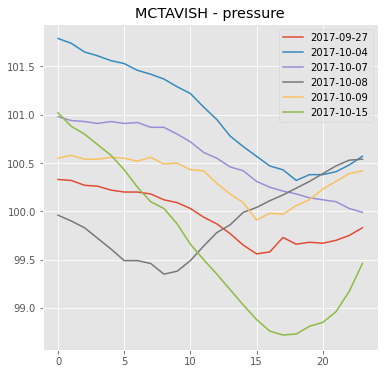

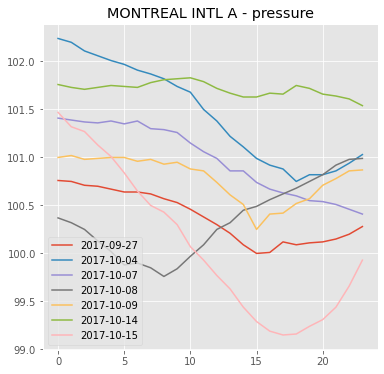

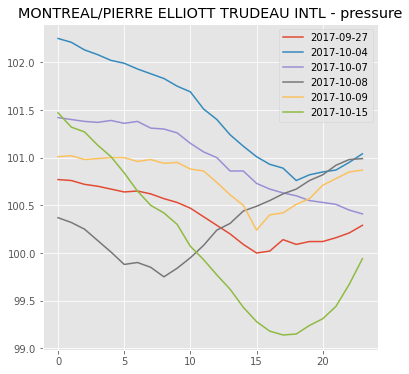

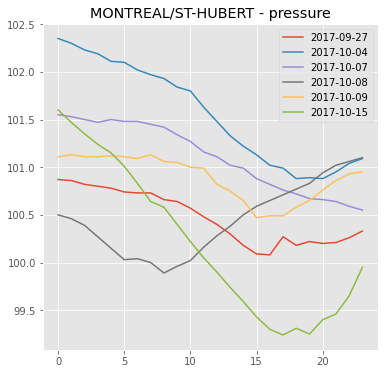

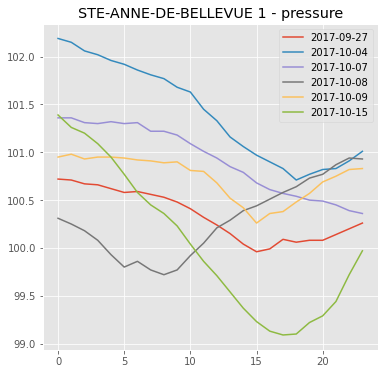

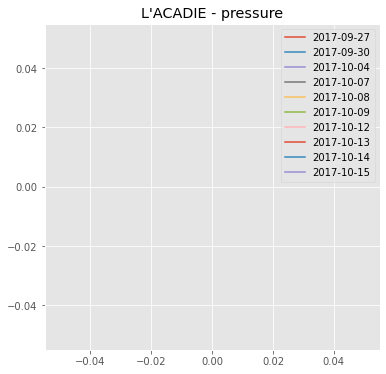

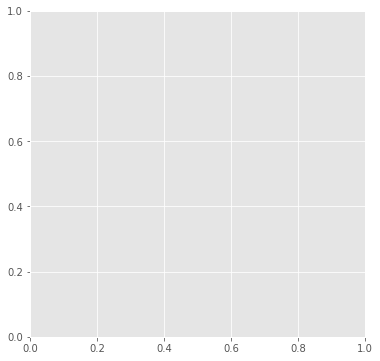

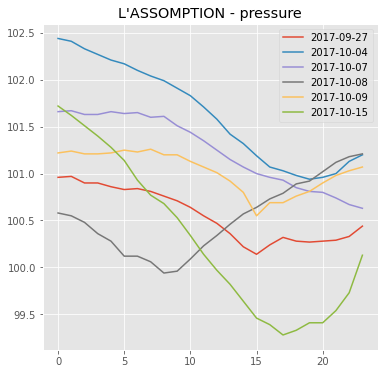

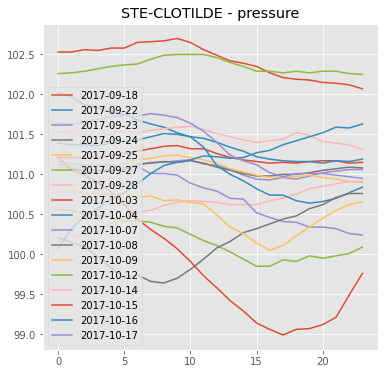

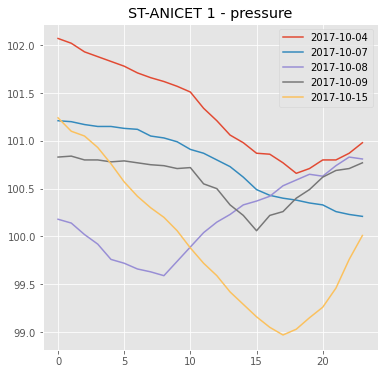

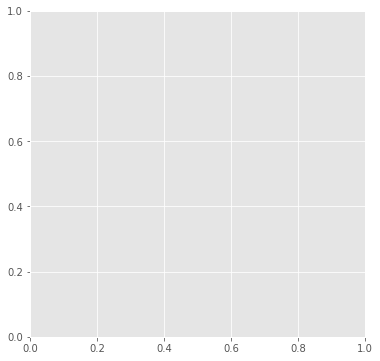

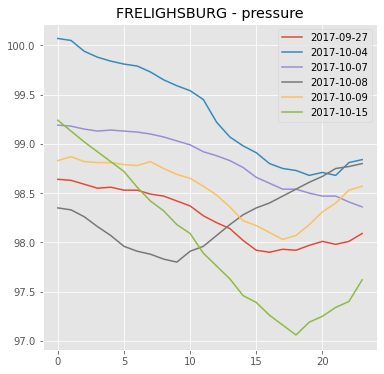

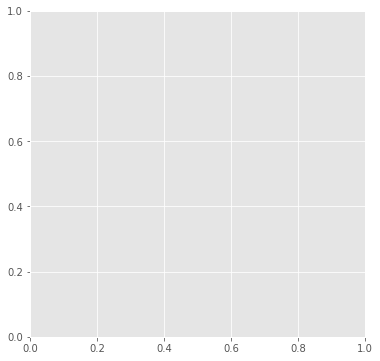

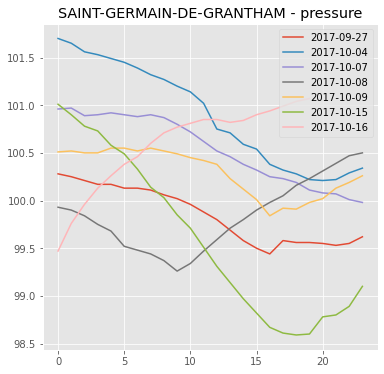

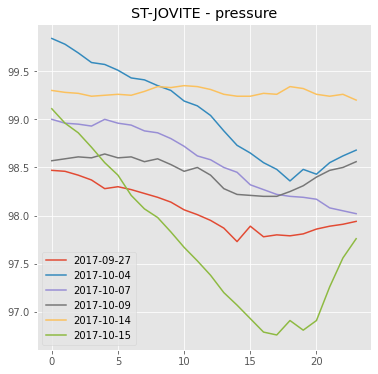

In [27]:
# plot pressure for each weather station where precip_flag = 1
for row in weather_stations['station_name']:
  fig, ax = plt.subplots(figsize = (6,6))
  precip_date = mtl_hourly['date'][(mtl_hourly['precip_flag'] == 1) & (mtl_hourly['station_name'] == row)].unique()

  for date in precip_date:
    subset = mtl_hourly[['hour', 'pressure']][(mtl_hourly['precip_flag'] == 1) & (mtl_hourly['station_name'] == row) & (mtl_hourly['date'] == date)]
    x = subset['hour']
    y = subset['pressure']

    plt.plot(x, y, label = date)
    plt.title(str(row) + ' - pressure')
    plt.legend()

  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the ear

Text(0.5, 0.98, 'Pressue By Weather Station - Precip (True)')

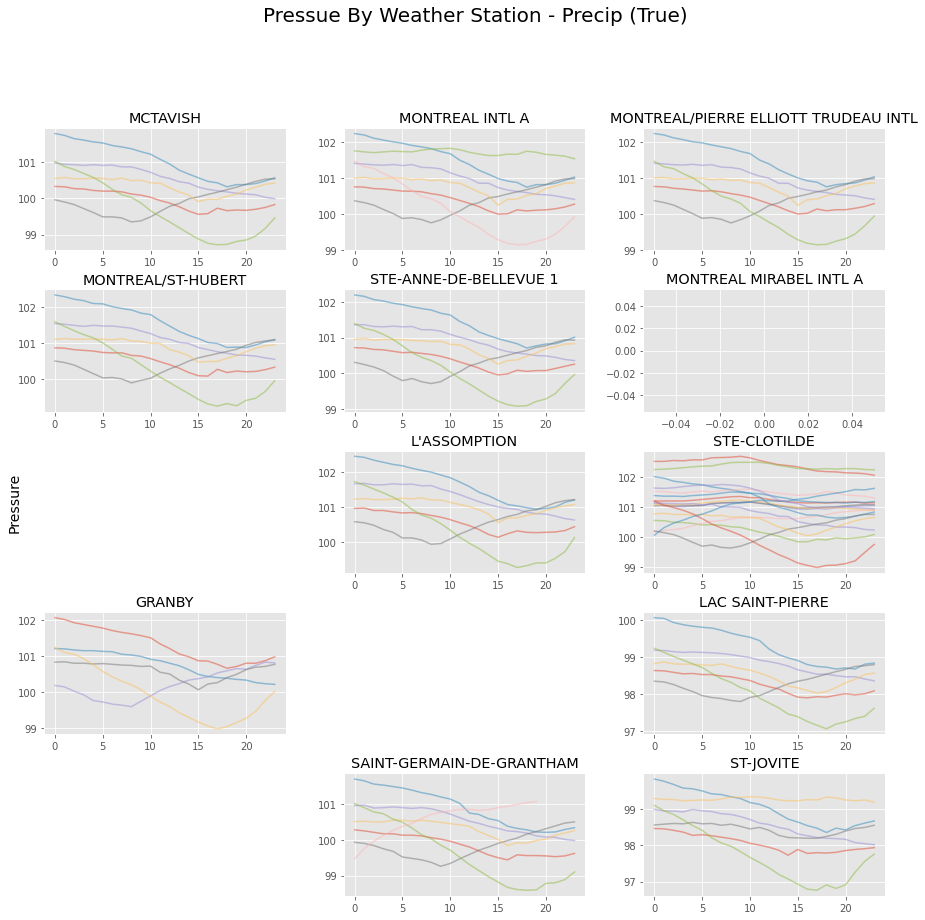

In [28]:
fig = plt.figure(figsize = (13, 13))
spec = gs.GridSpec(nrows= 5, ncols= 3, figure= fig)
i = 0

for row in weather_stations['station_name']:
  precip_date = mtl_hourly['date'][(mtl_hourly['precip_flag'] == 1) & (mtl_hourly['station_name'] == row)].unique()

  for date in precip_date:
    subset = mtl_hourly[['hour', 'pressure']][(mtl_hourly['precip_flag'] == 1) & (mtl_hourly['station_name'] == row) & (mtl_hourly['date'] == date)]
    x = subset['hour']
    y = subset['pressure']

    ax = plt.subplot(spec[i])
    ax.plot(x, y, alpha = 0.5)

  ax.set_title(row)

  i += 1

fig.text(0, 0.45, 'Pressure', rotation = 'vertical', va = 'center', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('Pressue By Weather Station - Precip (True)', fontsize = 20)


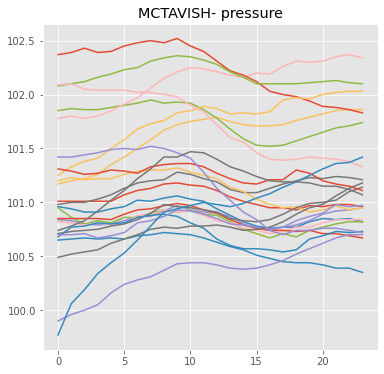

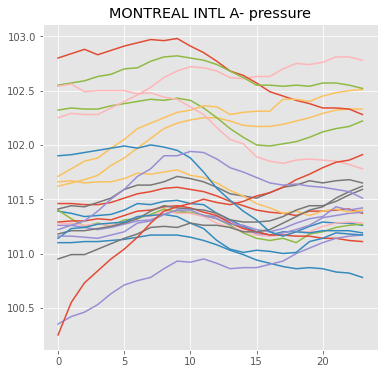

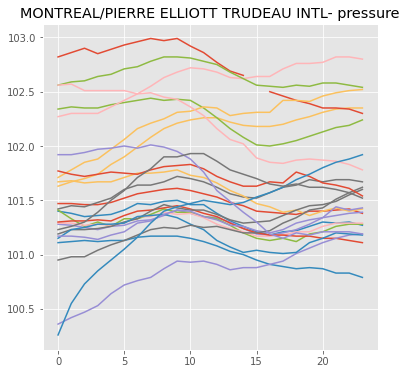

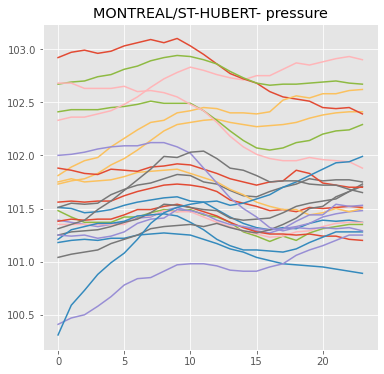

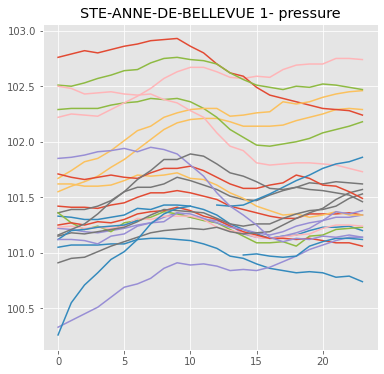

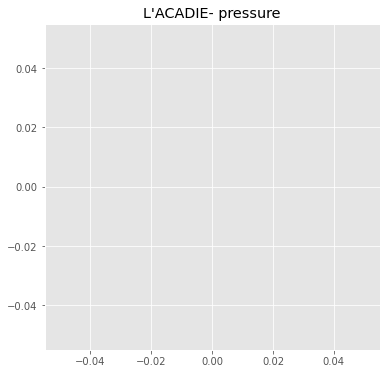

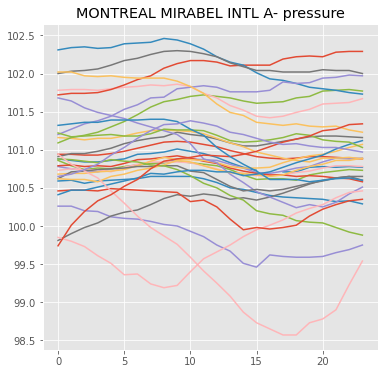

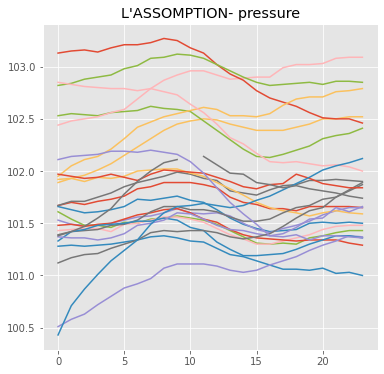

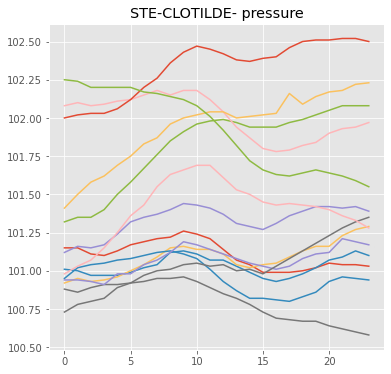

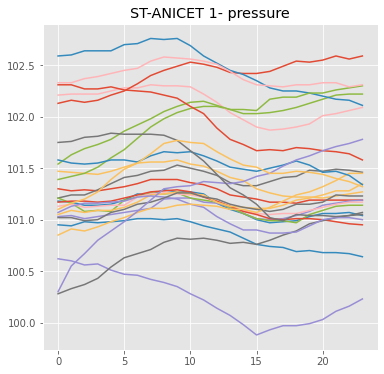

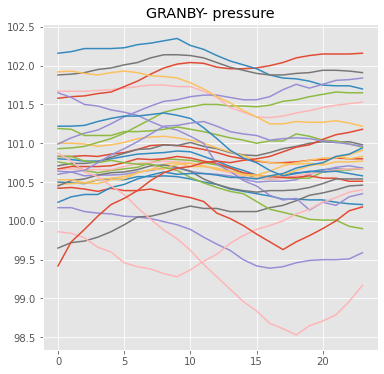

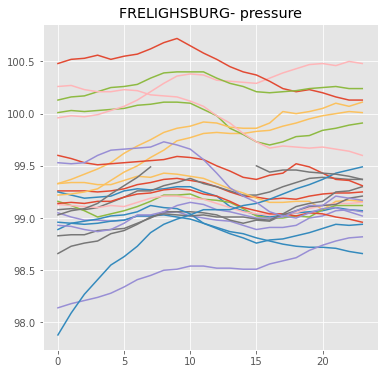

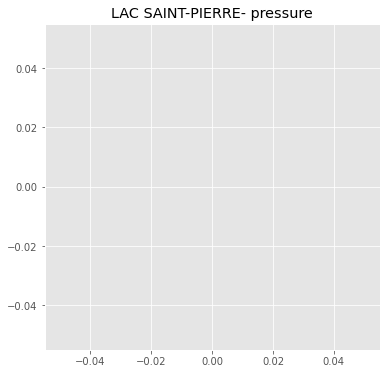

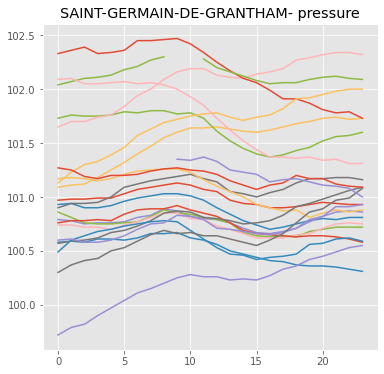

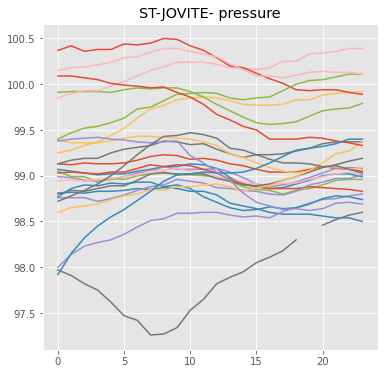

In [29]:
for row in weather_stations['station_name']:
  fig, ax = plt.subplots(figsize = (6,6))
  precip_date = mtl_hourly['date'][(mtl_hourly['precip_flag'] == 0) & (mtl_hourly['station_name'] == row)].unique()

  for date in precip_date:
    subset = mtl_hourly[['hour', 'pressure']][(mtl_hourly['precip_flag'] == 0) & (mtl_hourly['station_name'] == row) & (mtl_hourly['date'] == date)]
    x = subset['hour']
    y = subset['pressure']

    plt.plot(x, y, label = date)
    plt.title(str(row) + '- pressure')
    
  plt.show()



####**mtl_pts**

In [30]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/mtl trajet data')

Mounted at /content/drive


In [32]:
# set path for geojson files
mtl_pts_json = 'mtl_pts_2017_20200603.geojson'

In [33]:
# import file
mtl_pts = gpd.read_file(mtl_pts_json)
mtl_pts.head()

,latitude,longitude,speed,altitude,h_accuracy,v_accuracy,timestamp,id_trip,distance_weather,weather_station_id,weather_station_name,geometry
0,45.546167,-73.646082,8.31,37.781403,10.0,4.0,2017-09-18T10:03:52,150744,7.489362,10761,MCTAVISH,POINT (-73.64608 45.54617)
1,45.545952,-73.645344,13.60,38.696411,10.0,4.0,2017-09-18T10:03:57,150744,7.407557,10761,MCTAVISH,POINT (-73.64534 45.54595)
2,45.545662,-73.644330,14.79,39.560181,10.0,4.0,2017-09-18T10:04:03,150744,7.295210,10761,MCTAVISH,POINT (-73.64433 45.54566)
3,45.545451,-73.643589,11.87,39.500397,10.0,4.0,2017-09-18T10:04:08,150744,7.213132,10761,MCTAVISH,POINT (-73.64359 45.54545)
4,45.545226,-73.642798,11.63,40.618835,10.0,4.0,2017-09-18T10:04:15,150744,7.125531,10761,MCTAVISH,POINT (-73.64280 45.54523)


In [34]:
# create trip_seq_id for each id_trip
mtl_pts = mtl_pts.set_index(mtl_pts.groupby('id_trip').cumcount(), append = True)
mtl_pts = mtl_pts.reset_index()

del mtl_pts['level_0']

mtl_pts = mtl_pts.rename(columns= {'level_1' : 'id_trip_seq'})

In [ ]:
distance = []
station_id = []
station_name = []

# calculate nearest weather station
for row in mtl_pts['geometry']:
  # initialize distance
  min_distance = sys.maxsize
  for wthr_idx, wthr_row in weather_stations.iterrows():
    wthr_distance = vincenty((row.coords[0][0], row.coords[0][1]), (wthr_row[2].coords[0][0], wthr_row[2].coords[0][1]))
    if wthr_distance < min_distance:
      min_distance = wthr_distance
      min_station_id = wthr_row[0]
      min_station_name = wthr_row[1]

  distance.append(min_distance)
  station_id.append(min_station_id)
  station_name.append(min_station_name)

distance_series = pd.Series(distance)
station_id_series = pd.Series(station_id)
station_name_series = pd.Series(station_name)

station_id_series.head()

0    10761
1    10761
2    10761
3    10761
4    10761
dtype: int64

In [ ]:
mtl_pts = merge_series_df(mtl_pts, [distance_series, station_id_series, station_name_series], ['distance_weather', 'weather_station_id', 'weather_station_name'])

In [ ]:
mtl_pts.head()

,id_trip_seq,latitude,longitude,speed,altitude,h_accuracy,v_accuracy,timestamp,id_trip,geometry,distance_weather,weather_station_id,weather_station_name
0,0,45.546167,-73.646082,8.31,37.781403,10.0,4.0,2017-09-18T10:03:52,150744,POINT (-73.64608 45.54617),7.517066,10761,MCTAVISH
1,1,45.545952,-73.645344,13.60,38.696411,10.0,4.0,2017-09-18T10:03:57,150744,POINT (-73.64534 45.54595),7.434960,10761,MCTAVISH
2,2,45.545662,-73.644330,14.79,39.560181,10.0,4.0,2017-09-18T10:04:03,150744,POINT (-73.64433 45.54566),7.322200,10761,MCTAVISH
3,3,45.545451,-73.643589,11.87,39.500397,10.0,4.0,2017-09-18T10:04:08,150744,POINT (-73.64359 45.54545),7.239820,10761,MCTAVISH
4,4,45.545226,-73.642798,11.63,40.618835,10.0,4.0,2017-09-18T10:04:15,150744,POINT (-73.64280 45.54523),7.151897,10761,MCTAVISH


In [ ]:
# export mtl_pts (complete)
mtl_pts.to_file('mtl_pts_2017_COMPLETE.geojson', driver= 'GeoJSON')

In [38]:
# get max value for id_trip_seq
max_seq_id = mtl_pts[['id_trip', 'id_trip_seq']].groupby('id_trip')['id_trip_seq'].max().reset_index(name = 'num_coords')
# add 1 to num_coords
max_seq_id['num_coords'] = max_seq_id['num_coords'] + 1
max_seq_id.head()

,id_trip,num_coords
0,4,113
1,7,33
2,13,2
3,21,15
4,22,103


In [39]:
print ('no. of trips : {}'.format(len(mtl_pts['id_trip'].unique())))
# avg. no. of coords
print ('avg no. of coordinates per trip : {}'.format(max_seq_id['num_coords'].mean()))

no. of trips : 62771
avg no. of coordinates per trip : 77.10476175303883


In [35]:
# reduce size of each trip to a max. of 90 data points
# will use 75 datapoints, however collecting up to 90 data points to use for smoothing/moving average
print ('total no. of SMT coordinates : {}'.format(len(mtl_pts)))
mtl_pts_model = mtl_pts[mtl_pts['id_trip_seq'] < 90]
print ('total no. of SMT coordinates after reduction : {}'.format(len(mtl_pts_model)))

total no. of SMT coordinates : 4839943
total no. of SMT coordinates after reduction : 3068781


In [36]:
print ('no. of unique trips : {}'.format(len(mtl_pts_model['id_trip'].unique())))
print ('no. of id_trip_seq [0] : {}'.format(len(mtl_pts_model[mtl_pts_model['id_trip_seq'] == 0])))

no. of unique trips : 62771
no. of id_trip_seq [0] : 62771


In [ ]:
mtl_pts_model.head()

,id_trip_seq,latitude,longitude,speed,altitude,h_accuracy,v_accuracy,timestamp,id_trip,geometry,distance_weather,weather_station_id,weather_station_name
0,0,45.546167,-73.646082,8.31,37.781403,10.0,4.0,2017-09-18T10:03:52,150744,POINT (-73.64608 45.54617),7.517066,10761,MCTAVISH
1,1,45.545952,-73.645344,13.60,38.696411,10.0,4.0,2017-09-18T10:03:57,150744,POINT (-73.64534 45.54595),7.434960,10761,MCTAVISH
2,2,45.545662,-73.644330,14.79,39.560181,10.0,4.0,2017-09-18T10:04:03,150744,POINT (-73.64433 45.54566),7.322200,10761,MCTAVISH
3,3,45.545451,-73.643589,11.87,39.500397,10.0,4.0,2017-09-18T10:04:08,150744,POINT (-73.64359 45.54545),7.239820,10761,MCTAVISH
4,4,45.545226,-73.642798,11.63,40.618835,10.0,4.0,2017-09-18T10:04:15,150744,POINT (-73.64280 45.54523),7.151897,10761,MCTAVISH


In [40]:
# get frequency counts by weather station
mtl_pts_model['weather_station_name'].value_counts()

MCTAVISH                   2462893
MONTREAL INTL A             360791
MONTREAL/ST-HUBERT          109488
STE-ANNE-DE-BELLEVUE 1       50903
L'ASSOMPTION                 28495
L'ACADIE                     24044
MONTREAL MIRABEL INTL A      18732
STE-CLOTILDE                  5416
LAC SAINT-PIERRE              2405
FRELIGHSBURG                  2379
ST-ANICET 1                   2292
GRANBY                         943
Name: weather_station_name, dtype: int64

In [41]:
# get percent of total coordinates by weather station
mtl_pts_model['weather_station_name'].value_counts(normalize = True)

MCTAVISH                   0.802564
MONTREAL INTL A            0.117568
MONTREAL/ST-HUBERT         0.035678
STE-ANNE-DE-BELLEVUE 1     0.016587
L'ASSOMPTION               0.009285
L'ACADIE                   0.007835
MONTREAL MIRABEL INTL A    0.006104
STE-CLOTILDE               0.001765
LAC SAINT-PIERRE           0.000784
FRELIGHSBURG               0.000775
ST-ANICET 1                0.000747
GRANBY                     0.000307
Name: weather_station_name, dtype: float64

In [42]:
# create keys (year, month, day, hour) in order to join weather station data with mtl_pts
mtl_pts_model['timestamp'] = pd.to_datetime(mtl_pts_model['timestamp'])

# get year/month/day/hour
mtl_pts_model['year'] = mtl_pts_model['timestamp'].dt.year
mtl_pts_model['month'] = mtl_pts_model['timestamp'].dt.month
mtl_pts_model['day'] = mtl_pts_model['timestamp'].dt.day
mtl_pts_model['hour'] = mtl_pts_model['timestamp'].dt.hour

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [43]:
# merge weather station data with mtl_pts
mtl_pts_model = mtl_pts_model.merge(mtl_hourly[['station_id', 'year', 'month', 'day', 'hour', 'pressure', 'temp', 'temp_dew', 'wind_spd']], 
                                    how = 'left', 
                                    left_on = ['weather_station_id', 'year', 'month', 'day', 'hour'], 
                                    right_on = ['station_id', 'year', 'month', 'day', 'hour'])

In [44]:
mtl_pts_model.head()

,id_trip_seq,latitude,longitude,speed,altitude,h_accuracy,v_accuracy,timestamp,id_trip,distance_weather,weather_station_id,weather_station_name,geometry,year,month,day,hour,station_id,pressure,temp,temp_dew,wind_spd
0,0,45.546167,-73.646082,8.31,37.781403,10.0,4.0,2017-09-18 10:03:52,150744,7.489362,10761,MCTAVISH,POINT (-73.64608 45.54617),2017,9,18,10,10761,101.16,19.8,16.7,7.0
1,1,45.545952,-73.645344,13.60,38.696411,10.0,4.0,2017-09-18 10:03:57,150744,7.407557,10761,MCTAVISH,POINT (-73.64534 45.54595),2017,9,18,10,10761,101.16,19.8,16.7,7.0
2,2,45.545662,-73.644330,14.79,39.560181,10.0,4.0,2017-09-18 10:04:03,150744,7.295210,10761,MCTAVISH,POINT (-73.64433 45.54566),2017,9,18,10,10761,101.16,19.8,16.7,7.0
3,3,45.545451,-73.643589,11.87,39.500397,10.0,4.0,2017-09-18 10:04:08,150744,7.213132,10761,MCTAVISH,POINT (-73.64359 45.54545),2017,9,18,10,10761,101.16,19.8,16.7,7.0
4,4,45.545226,-73.642798,11.63,40.618835,10.0,4.0,2017-09-18 10:04:15,150744,7.125531,10761,MCTAVISH,POINT (-73.64280 45.54523),2017,9,18,10,10761,101.16,19.8,16.7,7.0


In [45]:
# calculate the percentage of the dataset that has missing values
# mtl_hourly[['station_id', 'year', 'month', 'day', 'hour', 'pressure', 'temp', 'temp_dew', 'wind_spd']]
len(mtl_pts_model[mtl_pts_model['pressure'].isna() == True])/len(mtl_pts_model)

0.009007811244921029

In [46]:
# calculate the percentage of the dataset that has missing values by trip_seq
weather_signals = ['pressure', 'temp', 'temp_dew', 'wind_spd']

for sig in weather_signals:
  print ('\n{} : '.format(sig))
  len(mtl_pts_model[mtl_pts_model[sig].isna() == True])/len(mtl_pts_model)
  print(mtl_pts_model['id_trip_seq'][mtl_pts_model[sig].isna() == True].value_counts())
  print(mtl_pts_model['weather_station_name'][mtl_pts_model[sig].isna() == True].value_counts())



pressure : 
1     449
0     448
2     443
3     434
4     428
     ... 
87    219
88    218
84    218
85    217
89    212
Name: id_trip_seq, Length: 90, dtype: int64
L'ACADIE                  24044
LAC SAINT-PIERRE           2405
STE-ANNE-DE-BELLEVUE 1      728
MONTREAL/ST-HUBERT          466
Name: weather_station_name, dtype: int64

temp : 
0     31
1     31
2     31
3     30
4     29
      ..
89     4
61     3
60     3
59     3
58     3
Name: id_trip_seq, Length: 90, dtype: int64
STE-ANNE-DE-BELLEVUE 1    728
MONTREAL/ST-HUBERT        466
Name: weather_station_name, dtype: int64

temp_dew : 
0     621
1     610
2     597
3     587
4     586
     ... 
85    200
86    199
89    199
87    199
88    198
Name: id_trip_seq, Length: 90, dtype: int64
L'ASSOMPTION              28153
STE-ANNE-DE-BELLEVUE 1      728
MONTREAL/ST-HUBERT          466
Name: weather_station_name, dtype: int64

wind_spd : 
0     31
1     31
2     31
3     30
4     29
      ..
89     4
61     3
60     3
59     3
58  

In [47]:
print ('no. of SMT trips : {}'.format(len(mtl_pts_model['id_trip'].unique())))

for sig in weather_signals:
  # find all id_trips that have at least on nan value
  weather_filter = mtl_pts_model['id_trip'][mtl_pts_model[sig].isna() == True].unique()
  # remove id_trips from modeling dataset
  mtl_pts_model = mtl_pts_model[~mtl_pts_model['id_trip'].isin(weather_filter)]
print ('no. of SMT trips (revised): {}'.format(len(mtl_pts_model['id_trip'].unique())))

no. of SMT trips : 62771
no. of SMT trips (revised): 61300


In [48]:
# get frequency counts by weather station
mtl_pts_model['weather_station_name'].value_counts()

MCTAVISH                   2436429
MONTREAL INTL A             360129
MONTREAL/ST-HUBERT           98502
STE-ANNE-DE-BELLEVUE 1       50050
MONTREAL MIRABEL INTL A      18687
STE-CLOTILDE                  5412
ST-ANICET 1                   2292
FRELIGHSBURG                   918
GRANBY                         336
L'ASSOMPTION                   298
Name: weather_station_name, dtype: int64

In [49]:
# get frequency counts by weather station
mtl_pts_model['weather_station_name'].value_counts(normalize = True)

MCTAVISH                   0.819504
MONTREAL INTL A            0.121131
MONTREAL/ST-HUBERT         0.033132
STE-ANNE-DE-BELLEVUE 1     0.016835
MONTREAL MIRABEL INTL A    0.006285
STE-CLOTILDE               0.001820
ST-ANICET 1                0.000771
FRELIGHSBURG               0.000309
GRANBY                     0.000113
L'ASSOMPTION               0.000100
Name: weather_station_name, dtype: float64

####**export file - mtl_pts**

In [50]:
# export mtl_pts to be used for modeling
export = mtl_pts_model[['latitude', 'longitude', 'speed', 'altitude', 'h_accuracy', 'v_accuracy', 'timestamp', 'id_trip', 'id_trip_seq', 'geometry', 'weather_station_id']]
export.head()

,latitude,longitude,speed,altitude,h_accuracy,v_accuracy,timestamp,id_trip,id_trip_seq,geometry,weather_station_id
0,45.546167,-73.646082,8.31,37.781403,10.0,4.0,2017-09-18 10:03:52,150744,0,POINT (-73.64608 45.54617),10761
1,45.545952,-73.645344,13.60,38.696411,10.0,4.0,2017-09-18 10:03:57,150744,1,POINT (-73.64534 45.54595),10761
2,45.545662,-73.644330,14.79,39.560181,10.0,4.0,2017-09-18 10:04:03,150744,2,POINT (-73.64433 45.54566),10761
3,45.545451,-73.643589,11.87,39.500397,10.0,4.0,2017-09-18 10:04:08,150744,3,POINT (-73.64359 45.54545),10761
4,45.545226,-73.642798,11.63,40.618835,10.0,4.0,2017-09-18 10:04:15,150744,4,POINT (-73.64280 45.54523),10761


In [52]:
export.to_file('mtl_pts_2017_MRP_20200730.geojson', driver = 'GeoJSON')

In [ ]:
mtl_pts.dtypes

latitude                 float64
longitude                float64
speed                    float64
altitude                 float64
h_accuracy               float64
v_accuracy               float64
timestamp                 object
id_trip                    int64
geometry                geometry
distance_weather         float64
weather_station_id         int64
weather_station_name      object
dtype: object

####**mtl_trajet**

In [ ]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/mtl trajet data')

Mounted at /content/drive


In [ ]:
# set path for geojson files
mtl_trajet_json = 'mtl_trajet_SMT_2017_20200602.geojson'

In [ ]:
mtl_trajet = gpd.read_file(mtl_trajet_json)
mtl_trajet.loc[:, mtl_trajet.columns != 'geometry'].head()

,id_trip,starttime,endtime,mode,purpose,num_modes_trans,trip_duration,trip_duration_secs,trip_duration_mins,day_of_week,hour,num_linestring,total_distance,total_coords,CDUID_start,CDNAME_start,CDUID_end,CDNAME_end,trip_start,trip_end,start_region_id,end_region_id
0,150744,2017-09-18T10:02:50,2017-09-18T10:17:12,automobile,Reconduire / aller chercher une personne,1.0,0 days 00:14:22,862,14.366667,0,10,1,11.475389,278,2466,Montréal,2466,Montréal,POINT (-73.646385 45.54629),POINT (-73.646385 45.54629),54,54
1,173651,2017-09-18T11:14:10,2017-09-18T12:01:46,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:47:36,2856,47.600000,0,11,1,14.444178,450,2473,Thérèse-De Blainville,2465,Laval,POINT (-73.81487199999999 45.644683),POINT (-73.81487199999999 45.644683),68,68
2,149086,2017-09-18T11:20:42,2017-09-18T12:10:14,public_transportation,Travail / Rendez-vous d'affaires,1.0,0 days 00:49:32,2972,49.533333,0,11,1,6.759736,253,2466,Montréal,2466,Montréal,POINT (-73.563513 45.516447),POINT (-73.563513 45.516447),39,39
3,358412,2017-09-18T11:27:38,2017-09-18T11:40:26,walk,Travail / Rendez-vous d'affaires,1.0,0 days 00:12:48,768,12.800000,0,11,1,0.836025,58,2466,Montréal,2466,Montréal,POINT (-73.590244 45.53261),POINT (-73.590244 45.53261),55,55
4,350121,2017-09-18T11:31:56,2017-09-18T12:11:26,automobile,Travail / Rendez-vous d'affaires,1.0,0 days 00:39:30,2370,39.500000,0,11,2,22.787044,975,2457,La Vallée-du-Richelieu,2456,Le Haut-Richelieu,POINT (-73.19817500000001 45.556559),POINT (-73.19817500000001 45.556559),59,59


In [ ]:
# query all unique id_trip from mtl_pts_model
id_trip_model = mtl_pts_model['id_trip'].unique()
print ('total no. of trips : {}'.format(len(id_trip_model)))

total no. of trips : 61342


In [ ]:
# exclude trips where id_trip is not in mtl_pts_model
mtl_trajet = mtl_trajet[mtl_trajet['id_trip'].isin(id_trip_model)]
print ('total no. of trips : {}'.format(len(mtl_trajet['id_trip'].unique())))

total no. of trips : 61342


In [ ]:
mtl_trajet.dtypes

id_trip                  int64
starttime               object
endtime                 object
mode                    object
purpose                 object
num_modes_trans        float64
trip_duration           object
trip_duration_secs       int64
trip_duration_mins     float64
day_of_week              int64
hour                     int64
num_linestring           int64
total_distance         float64
total_coords             int64
CDUID_start              int64
CDNAME_start            object
CDUID_end                int64
CDNAME_end              object
trip_start              object
trip_end                object
start_region_id          int64
end_region_id            int64
geometry              geometry
dtype: object

In [ ]:
mtl_trajet.to_file('mtl_trajet_2017_MRP.geojson', driver = 'GeoJSON')